---
---

In [2]:
# %% [IMPORT ALL REQUIRED LIBRARIES]

In [142]:
# Install faker

In [143]:
!pip install faker

In [3]:
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

In [6]:
import random

In [7]:
from faker import Faker

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
import seaborn as sns

In [11]:
import re

In [12]:
import nltk

In [13]:
from nltk.corpus import stopwords

In [14]:
from nltk.stem import WordNetLemmatizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest


In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.svm import SVC

In [21]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
import joblib

In [24]:
import matplotlib.pyplot as plt

In [25]:
import seaborn as sns

In [26]:
import pickle

In [27]:
from scipy.sparse import hstack

In [28]:
from flask import Flask, request, jsonify

---
---

---
---

In [29]:
# Initialize Faker

In [30]:
fake = Faker()

In [31]:
# Predefined institution list

In [32]:
institutions = [
    "MIT", "Stanford", "Harvard", "Caltech", "Oxford", "Cambridge",
    "UC Berkeley", "ETH Zurich", "University of Tokyo", "Imperial College London"
]

In [33]:
# Function to generate synthetic record

In [34]:
def generate_record():
    title = fake.catch_phrase()
    abstract = fake.paragraph(nb_sentences=5)
    budget = random.randint(10000, 200000)
    research_impact = random.randint(1, 10)
    references = random.randint(0, 50)
    institution = random.choice(institutions)
    applicant_experience = random.randint(0, 30)

    # Funded label: based on a heuristic (you can improve this logic)
    # Higher chance if high impact, more experience, more references
    prob_funded = (
        0.4 * (research_impact / 10) +
        0.3 * (applicant_experience / 30) +
        0.2 * (references / 50) +
        0.1 * (budget < 100000)
    )
    funded = 1 if random.random() < prob_funded else 0

    return {
        "Title": title,
        "Abstract": abstract,
        "Budget": budget,
        "Research_Impact": research_impact,
        "References": references,
        "Institution": institution,
        "Applicant_Experience": applicant_experience,
        "Funded": funded
    }

In [35]:
# Generate 10,000 records
data = [generate_record() for _ in range(10000)]

In [36]:
# Create DataFrame
df = pd.DataFrame(data)

In [37]:
# Save to CSV
df.to_csv("/content/grant_proposals_synthetic.csv", index=False)

In [38]:
# Show sample
df.head()

,Title,Abstract,Budget,Research_Impact,References,Institution,Applicant_Experience,Funded
0,Cross-platform cohesive projection,Level difficult management institution. Window...,96208,5,0,Oxford,14,0
1,Focused asymmetric customer loyalty,Image loss leg account find people sure. Walk ...,151133,10,0,UC Berkeley,22,1
2,Future-proofed bifurcated website,Important Republican skin animal officer term ...,147018,1,44,Oxford,22,1
3,Integrated leadingedge array,Wish life before weight see look serve because...,61530,2,0,Harvard,13,0
4,Automated solution-oriented complexity,Collection significant art receive. Cause cour...,90920,1,44,Cambridge,17,1


---
---

---
---

In [39]:
# %% [EDA]

In [40]:
# Load the dataset
file_path = '/content/grant_proposals_synthetic.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!\n")

    # Display basic information about the dataset
    print("=====================================")
    print("DATASET INFORMATION")
    print("=====================================")
    print(df.info())

    # Display the first 5 rows of the dataset
    print("\n=====================================")
    print("FIRST 5 ROWS OF THE DATASET")
    print("=====================================")
    print(df.head())

    # Display descriptive statistics for numerical columns
    print("\n=====================================")
    print("DESCRIPTIVE STATISTICS")
    print("=====================================")
    print(df.describe(include='all'))

    # Check for missing values
    print("\n=====================================")
    print("MISSING VALUES CHECK")
    print("=====================================")
    print(df.isnull().sum())

    # Check class distribution (funded vs not funded)
    if 'label' in df.columns or 'funded' in df.columns or 'status' in df.columns:
        label_col = 'label' if 'label' in df.columns else ('funded' if 'funded' in df.columns else 'status')
        print("\n=====================================")
        print("CLASS DISTRIBUTION")
        print("=====================================")
        print(df[label_col].value_counts())
        print("\nClass percentages:")
        print(df[label_col].value_counts(normalize=True) * 100)

    # Display text column statistics if exists
    text_cols = [col for col in df.columns if df[col].dtype == 'object' and col != label_col]
    if text_cols:
        text_col = text_cols[0]  # assuming first text column is the proposal text
        print("\n=====================================")
        print("TEXT DATA STATISTICS")
        print("=====================================")
        print(f"Column '{text_col}' contains the grant proposals")
        df['text_length'] = df[text_col].apply(len)
        print("\nText length statistics (in characters):")
        print(df['text_length'].describe())

        # Word count statistics
        df['word_count'] = df[text_col].apply(lambda x: len(str(x).split()))
        print("\nWord count statistics:")
        print(df['word_count'].describe())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Dataset loaded successfully!

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 10000 non-null  object
 1   Abstract              10000 non-null  object
 2   Budget                10000 non-null  int64 
 3   Research_Impact       10000 non-null  int64 
 4   References            10000 non-null  int64 
 5   Institution           10000 non-null  object
 6   Applicant_Experience  10000 non-null  int64 
 7   Funded                10000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 625.1+ KB
None

FIRST 5 ROWS OF THE DATASET
                                    Title  \
0      Cross-platform cohesive projection   
1     Focused asymmetric customer loyalty   
2       Future-proofed bifurcated website   
3            Integrated leadingedge array   
4  Automated solution-oriented c

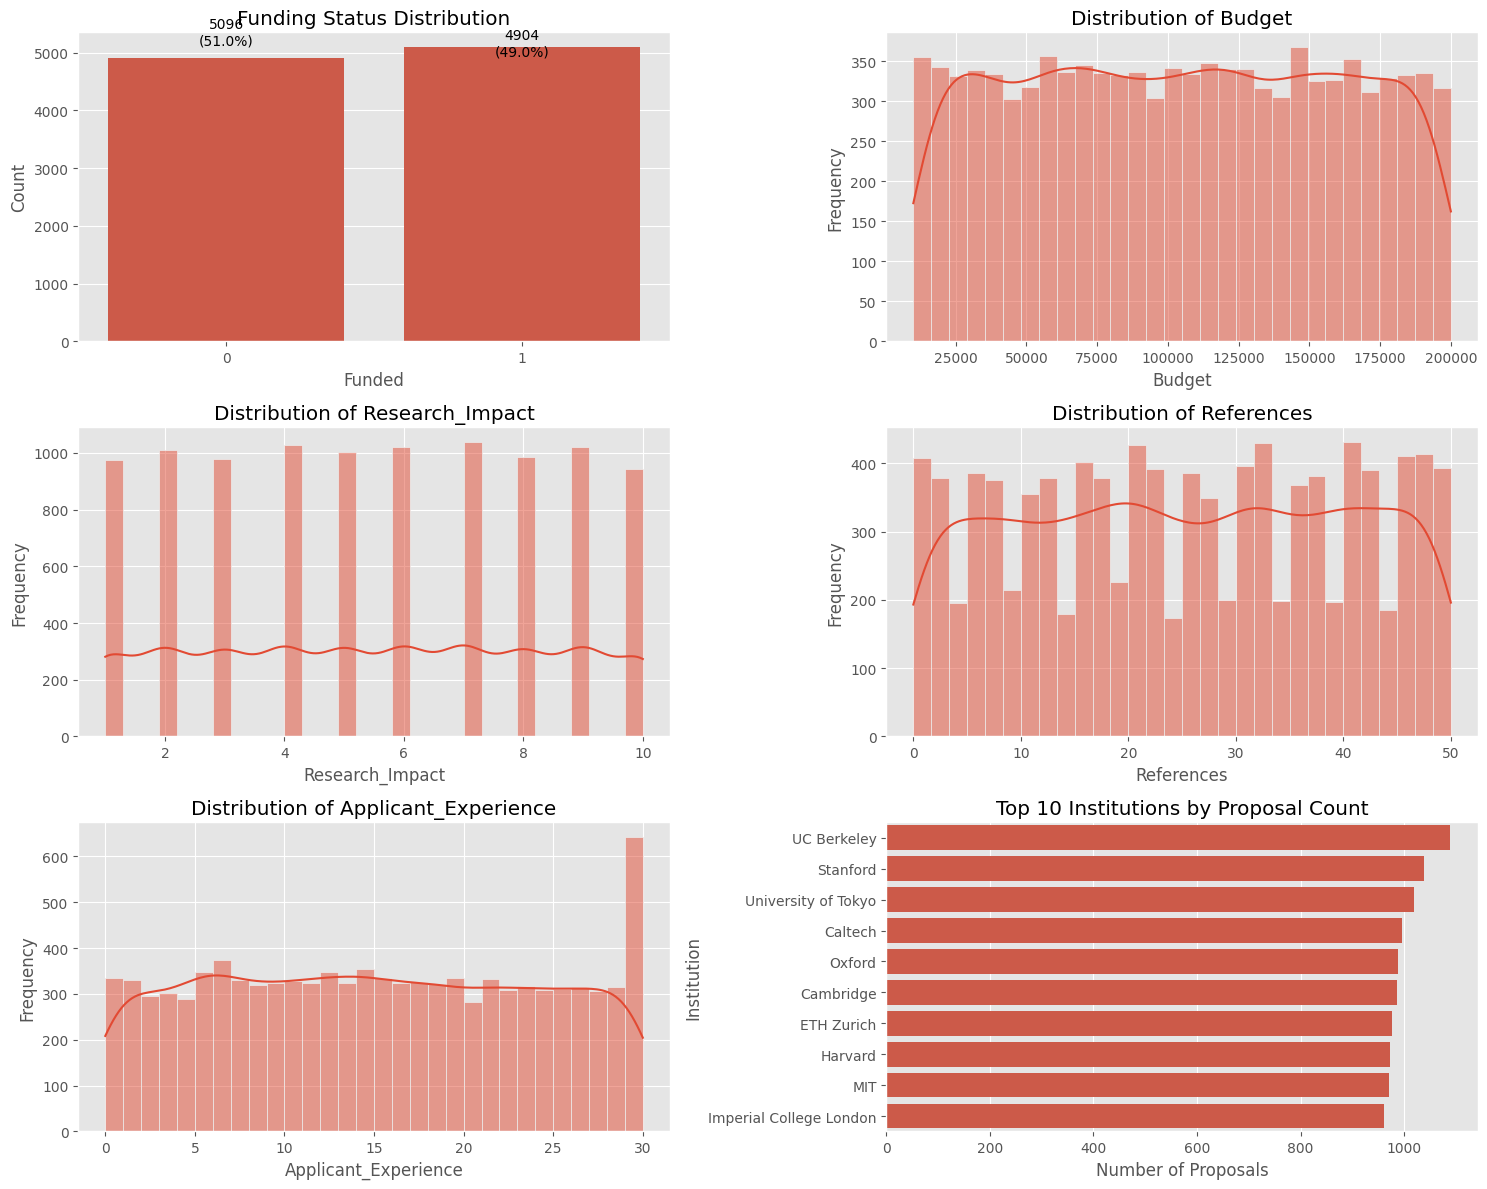

In [41]:
# Set up the visualization style
plt.style.use('ggplot')
plt.figure(figsize=(15, 12))
# 1. Funding Status Distribution
plt.subplot(3, 2, 1)
funding_dist = df['Funded'].value_counts()
sns.barplot(x=funding_dist.index, y=funding_dist.values)
plt.title('Funding Status Distribution')
plt.xlabel('Funded')
plt.ylabel('Count')
for i, v in enumerate(funding_dist.values):
    plt.text(i, v, f"{v}\n({v/len(df)*100:.1f}%)", ha='center', va='bottom')

# 2. Numerical Features Distributions
num_cols = ['Budget', 'Research_Impact', 'References', 'Applicant_Experience']

for i, col in enumerate(num_cols, 2):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# 3. Institution Distribution (Top 10)
plt.subplot(3, 2, 6)
institution_counts = df['Institution'].value_counts().head(10)
sns.barplot(y=institution_counts.index, x=institution_counts.values)
plt.title('Top 10 Institutions by Proposal Count')
plt.xlabel('Number of Proposals')
plt.ylabel('Institution')

plt.tight_layout()
plt.show()

In [42]:
# 4. Correlation Analysis

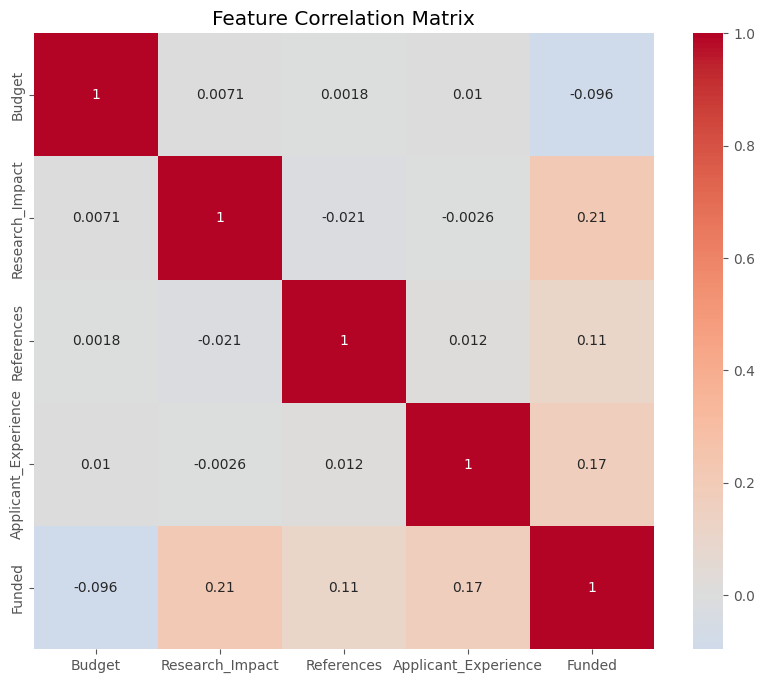

In [43]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [44]:
# 5. Text Length Analysis


TEXT LENGTH ANALYSIS
Abstract length (characters):
count    10000.000000
mean       166.740600
std         48.131973
min         57.000000
25%        127.000000
50%        165.000000
75%        204.000000
max        320.000000
Name: Abstract_Length, dtype: float64

Title length (characters):
count    10000.000000
mean        33.440600
std          5.717984
min         17.000000
25%         29.000000
50%         33.000000
75%         37.000000
max         59.000000
Name: Title_Length, dtype: float64


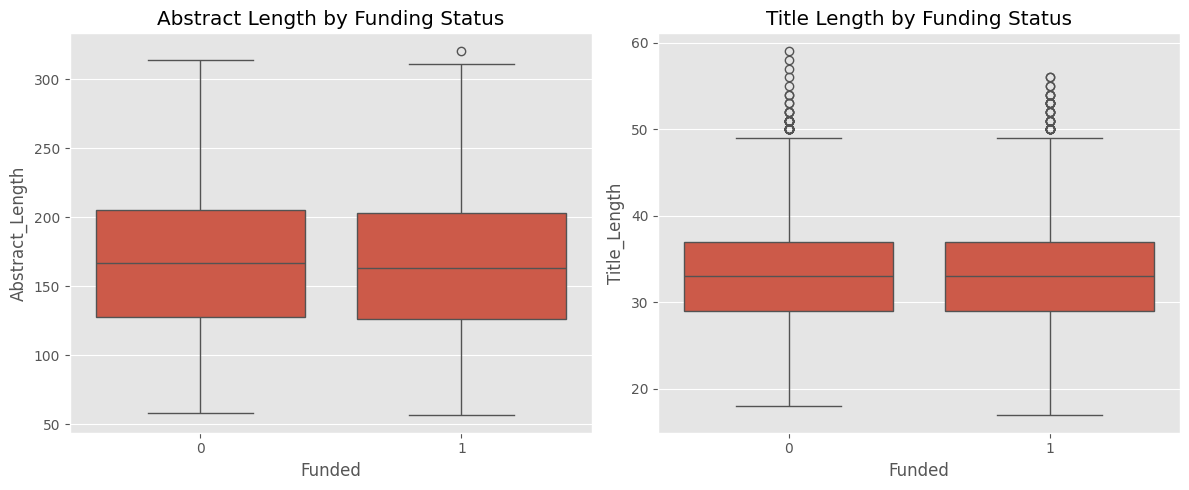

In [45]:
df['Abstract_Length'] = df['Abstract'].apply(len)
df['Title_Length'] = df['Title'].apply(len)

print("\n" + "="*50)
print("TEXT LENGTH ANALYSIS")
print("="*50)
print("Abstract length (characters):")
print(df['Abstract_Length'].describe())
print("\nTitle length (characters):")
print(df['Title_Length'].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Funded', y='Abstract_Length', data=df)
plt.title('Abstract Length by Funding Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='Funded', y='Title_Length', data=df)
plt.title('Title Length by Funding Status')
plt.tight_layout()
plt.show()

---
---

---
---

In [46]:
# %% [DOWNLOAD NLTK DATA]

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
nltk.download('punkt_tab')  # Ensure punkt_tab is also downloaded

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

---
---

---
---

In [51]:
# %% [DATA LOADING]

In [52]:
df = pd.read_csv('/content/grant_proposals_synthetic.csv')

---
---

---
---

In [53]:
# %% [TEXT CLEANING FUNCTION]

In [54]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

---
---

---
---

In [55]:
# %% [INITIALIZE TEXT PROCESSING TOOLS]

In [56]:
stop_words = set(stopwords.words('english'))

In [57]:
lemmatizer = WordNetLemmatizer()

---
---

---
---

In [58]:
# %% [APPLY TEXT CLEANING]

In [59]:
df['Clean_Title'] = df['Title'].apply(clean_text)

In [60]:
df['Clean_Abstract'] = df['Abstract'].apply(clean_text)

---
---

---
---

In [61]:
# %% [FEATURE ENGINEERIN]

In [62]:
df['Title_Length'] = df['Title'].apply(len)

In [63]:
df['Abstract_Length'] = df['Abstract'].apply(len)

In [64]:
df['Budget_to_Experience'] = df['Budget'] / (df['Applicant_Experience'] + 1)


In [65]:
institution_dummies = pd.get_dummies(df['Institution'], prefix='Inst')

In [66]:
df = pd.concat([df, institution_dummies], axis=1)

---
---

---
---

In [67]:
# %% [TEXT VECTORIZATION]

In [68]:
title_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))


In [69]:
title_features = title_vectorizer.fit_transform(df['Clean_Title'])

In [70]:
abstract_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))


In [71]:
abstract_features = abstract_vectorizer.fit_transform(df['Clean_Abstract'])


In [72]:
from scipy.sparse import hstack

In [73]:
text_features = hstack([title_features, abstract_features])

---
---

---
---

In [74]:
# %% [NUMERICAL FEATURE PROCESSING]

In [75]:
num_features = df[['Budget', 'Research_Impact', 'References', 'Applicant_Experience', 'Title_Length', 'Abstract_Length', 'Budget_to_Experience']]


In [76]:
scaler = StandardScaler()

In [77]:
scaled_num_features = scaler.fit_transform(num_features)

---
---

---
---

In [78]:
# %% [CREATE FINAL FEATURE MATRIX ]

In [79]:
institution_features = df.filter(regex='^Inst_').values

In [80]:
X = np.hstack([text_features.toarray(), scaled_num_features, institution_features])


In [81]:
y = df['Funded']

---
---

---
---

In [82]:
# %% [TRAIN-TEST SPLIT]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


---
---

---
---

In [84]:
# %% [MODEL TRAINING AND EVALUATION]

In [85]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": GradientBoostingClassifier(n_estimators=200),
    "SVM": SVC(kernel='rbf', probability=True)
}

In [86]:
print("=== MODEL PERFORMANCE ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

=== MODEL PERFORMANCE ===

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       981
           1       0.62      0.64      0.63      1019

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

F1-Score: 0.6255
ROC-AUC: 0.6642

Random Forest Results:
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       981
           1       0.62      0.64      0.63      1019

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

F1-Score: 0.6292
ROC-AUC: 0.6584

XGBoost Results:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       981
           1       0.64      0.65      0.64      1019

    accuracy      

---
---

---
---

In [87]:
# %% [HYPERPARAMETER TUNING (XGBOOST]

In [88]:
print("\n=== HYPERPARAMETER TUNING ===")
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}


=== HYPERPARAMETER TUNING ===


In [89]:
grid = GridSearchCV(GradientBoostingClassifier(), params, cv=3, scoring='f1', n_jobs=-1)


In [90]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [91]:
best_model = grid.best_estimator_

In [92]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Validation F1: {grid.best_score_:.4f}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Validation F1: 0.6341


---
---

---
---

In [93]:
# %% [ANOMALY DETECTION]

In [94]:
X_funded = X[y == 1]

In [95]:
fraud_detector = IsolationForest(contamination=0.05, random_state=42)

In [96]:
fraud_detector.fit(X_funded)

IsolationForest(contamination=0.05, random_state=42)

---
---

----
----

In [97]:
# %% [SAVE ALL MODELS]

In [98]:
joblib.dump(best_model, 'grant_model.pkl')
joblib.dump(title_vectorizer, 'title_vectorizer.pkl')
joblib.dump(abstract_vectorizer, 'abstract_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(fraud_detector, 'fraud_detector.pkl')

['fraud_detector.pkl']

In [99]:
print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
print("Saved models:")
print("- grant_model.pkl (main classifier)")
print("- title_vectorizer.pkl")
print("- abstract_vectorizer.pkl")
print("- scaler.pkl")
print("- fraud_detector.pkl")


=== PIPELINE COMPLETED SUCCESSFULLY ===
Saved models:
- grant_model.pkl (main classifier)
- title_vectorizer.pkl
- abstract_vectorizer.pkl
- scaler.pkl
- fraud_detector.pkl


----
---

----
---

In [100]:
# %% [Load the models]

In [101]:
grant_model = joblib.load('grant_model.pkl')
title_vectorizer = joblib.load('title_vectorizer.pkl')
abstract_vectorizer = joblib.load('abstract_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')
fraud_detector = joblib.load('fraud_detector.pkl')

In [102]:
# Example dataframe df

In [103]:
df = pd.DataFrame({
    'Title': ['Grant Proposal 1', 'Grant Proposal 2'],
    'Abstract': ['Abstract 1', 'Abstract 2'],
    'Feature1': [1.0, 2.0],
    'Feature2': [3.0, 4.0]
})

In [104]:
# Example: Automatically detect numerical columns

In [105]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [106]:
# Train vectorizers and scaler

In [107]:
title_vectorizer = TfidfVectorizer()

In [108]:
abstract_vectorizer = TfidfVectorizer()

In [109]:
scaler = StandardScaler()

In [110]:
# Train the vectorizers and scaler

In [111]:
title_vectorizer.fit(df['Title'])

TfidfVectorizer()

In [112]:
abstract_vectorizer.fit(df['Abstract'])

TfidfVectorizer()

In [113]:
scaler.fit(df[numerical_features])

StandardScaler()

In [114]:
# Train the model

In [115]:
target = [0, 1]  # Example target variable for classification

In [116]:
grant_model = GradientBoostingClassifier()

In [117]:
grant_model.fit(df[numerical_features], target)  # Fit the model with numerical features and target


GradientBoostingClassifier()

In [118]:
# Save the models

In [119]:
with open('title_vectorizer.pkl', 'wb') as f:
    pickle.dump(title_vectorizer, f)
with open('abstract_vectorizer.pkl', 'wb') as f:
    pickle.dump(abstract_vectorizer, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('grant_model.pkl', 'wb') as f:
    pickle.dump(grant_model, f)

In [120]:
# Load the saved models for later use

In [121]:
with open('title_vectorizer.pkl', 'rb') as f:
    title_vectorizer = pickle.load(f)
with open('abstract_vectorizer.pkl', 'rb') as f:
    abstract_vectorizer = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('grant_model.pkl', 'rb') as f:
    grant_model = pickle.load(f)

In [122]:
# Example of making predictions using the trained model

In [123]:
new_data = {
    'Title': ['New Grant Proposal'],
    'Abstract': ['This is a new grant proposal abstract.'],
    'Feature1': [2.5],
    'Feature2': [3.5]
}

In [124]:
new_df = pd.DataFrame(new_data)

In [125]:
# Only extract numerical features for prediction (do not include text features here)


In [126]:
scaled_num_features = scaler.transform(new_df[numerical_features])

In [127]:
# Convert the scaled features back into a DataFrame with proper feature names


In [128]:
scaled_num_features_df = pd.DataFrame(scaled_num_features, columns=numerical_features)


In [129]:
# Predict using the trained model

In [130]:
prediction = grant_model.predict(scaled_num_features_df)

In [131]:
# Output the prediction (1 = Funded, 0 = Not Funded)

In [132]:
if prediction == 1:
    print("The grant proposal is predicted to be funded.")
else:
    print("The grant proposal is predicted to not be funded.")

The grant proposal is predicted to be funded.


----
----

---
---

In [133]:
# %% [DEPLOYMENT-INTERACTIVE DASHBOARD]

In [134]:
# Load models and vectorizers

In [135]:
grant_model = joblib.load('grant_model.pkl')

In [136]:
title_vectorizer = joblib.load('title_vectorizer.pkl')

In [137]:
abstract_vectorizer = joblib.load('abstract_vectorizer.pkl')

In [138]:
scaler = joblib.load('scaler.pkl')

In [139]:
# Initialize Flask app

In [140]:
app = Flask(__name__)

In [141]:
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()  # Get the incoming JSON data

    # Extract features from the request
    new_title = data['Title']
    new_abstract = data['Abstract']
    new_budget = data['Budget']
    new_research_impact = data['Research_Impact']
    new_references = data['References']
    new_experience = data['Experience']

    # Clean the text (use the cleaning function from the earlier code)
    cleaned_title = clean_text(new_title)
    cleaned_abstract = clean_text(new_abstract)

    # Vectorize the text
    title_features = title_vectorizer.transform([cleaned_title])
    abstract_features = abstract_vectorizer.transform([cleaned_abstract])
    text_features = hstack([title_features, abstract_features])

    # Scale the numerical features
    numerical_features = np.array([[new_budget, new_research_impact, new_references, new_experience]])
    scaled_num_features = scaler.transform(numerical_features)

    # Combine text and numerical features
    final_features = np.hstack([text_features.toarray(), scaled_num_features])

    # Make prediction
    prediction = grant_model.predict(final_features)

    # Return the prediction as a response
    return jsonify({'Prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


---
---